In [117]:
from typing import List

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ML procedures
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, GroupKFold

# ML models
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [113]:
DATA_DIR = "data"

TRAIN_IDS: List[str] = [
    "1mpau",
    "2nxs5",
    "5gpsc",
    "7swyk",
    "8a1ep",
    "b7mrd",
    "c24ur",
    "dkhty",
    "e4gay",
    "ef5rq",
    "f3j25",
    "hpbxa",
    "ibvx8",
    "iz2ps",
    "rc1in",
    "tn4vl",
    "wjxci",
    "yljm5",
]
TEST_IDS: List[str] = ["3caqi", "6frz4", "bd47a", "f1gjp", "iz3x1"]

In [114]:
warnings.simplefilter("ignore")

sns.set()

In [115]:
def get_io(
    feature_df: pd.DataFrame, label_df: pd.DataFrame, user_ids: List[str]
) -> [pd.DataFrame, np.ndarray]:
    X_ = []
    y_ = []

    for user_id in user_ids:
        X_.append(feature_df[label_df.user_id == user_id])
        y_.extend(
            np.array(
                [
                    0 if label == "rest" else 1
                    for label in label_df.loc[
                        label_df.user_id == user_id, "level"
                    ].values
                ]
            )
        )

    return pd.concat(X_), np.array(y_)


def train_test_split(
    data_dir: str, train_ids: List[str], test_ids: List[str]
) -> [pd.DataFrame, np.ndarray, pd.DataFrame, np.ndarray]:
    feature_df: pd.DataFrame = pd.read_csv(f"{data_dir}/features.csv").drop(
        "Unnamed: 0", axis=1
    )
    label_df: pd.DataFrame = pd.read_csv(f"{data_dir}/labels.csv")

    train_data: [pd.DataFrame, np.ndarray] = get_io(
        feature_df=feature_df, label_df=label_df, user_ids=train_ids
    )
    test_data: [pd.DataFrame, np.ndarray] = get_io(
        feature_df=feature_df, label_df=label_df, user_ids=test_ids
    )

    return train_data + test_data

In [116]:
X_train, y_train, X_test, y_test = train_test_split(DATA_DIR, TRAIN_IDS, TEST_IDS)

print("Train data:", X_train.shape, y_train.shape)
print("Test data:", X_test.shape, y_test.shape)

Train data: (645, 106) (645,)
Test data: (193, 106) (193,)


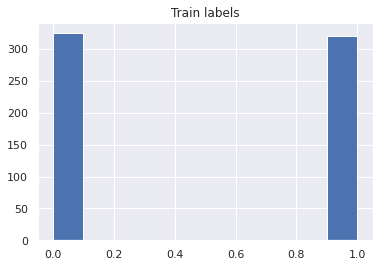

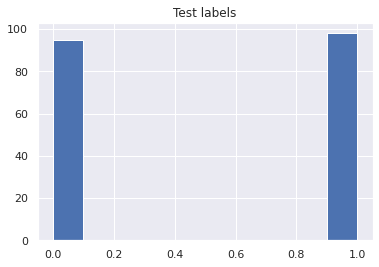

In [92]:
plt.hist(y_train)
plt.title("Train labels")
plt.show()

plt.hist(y_test)
plt.title("Test labels")
plt.show()

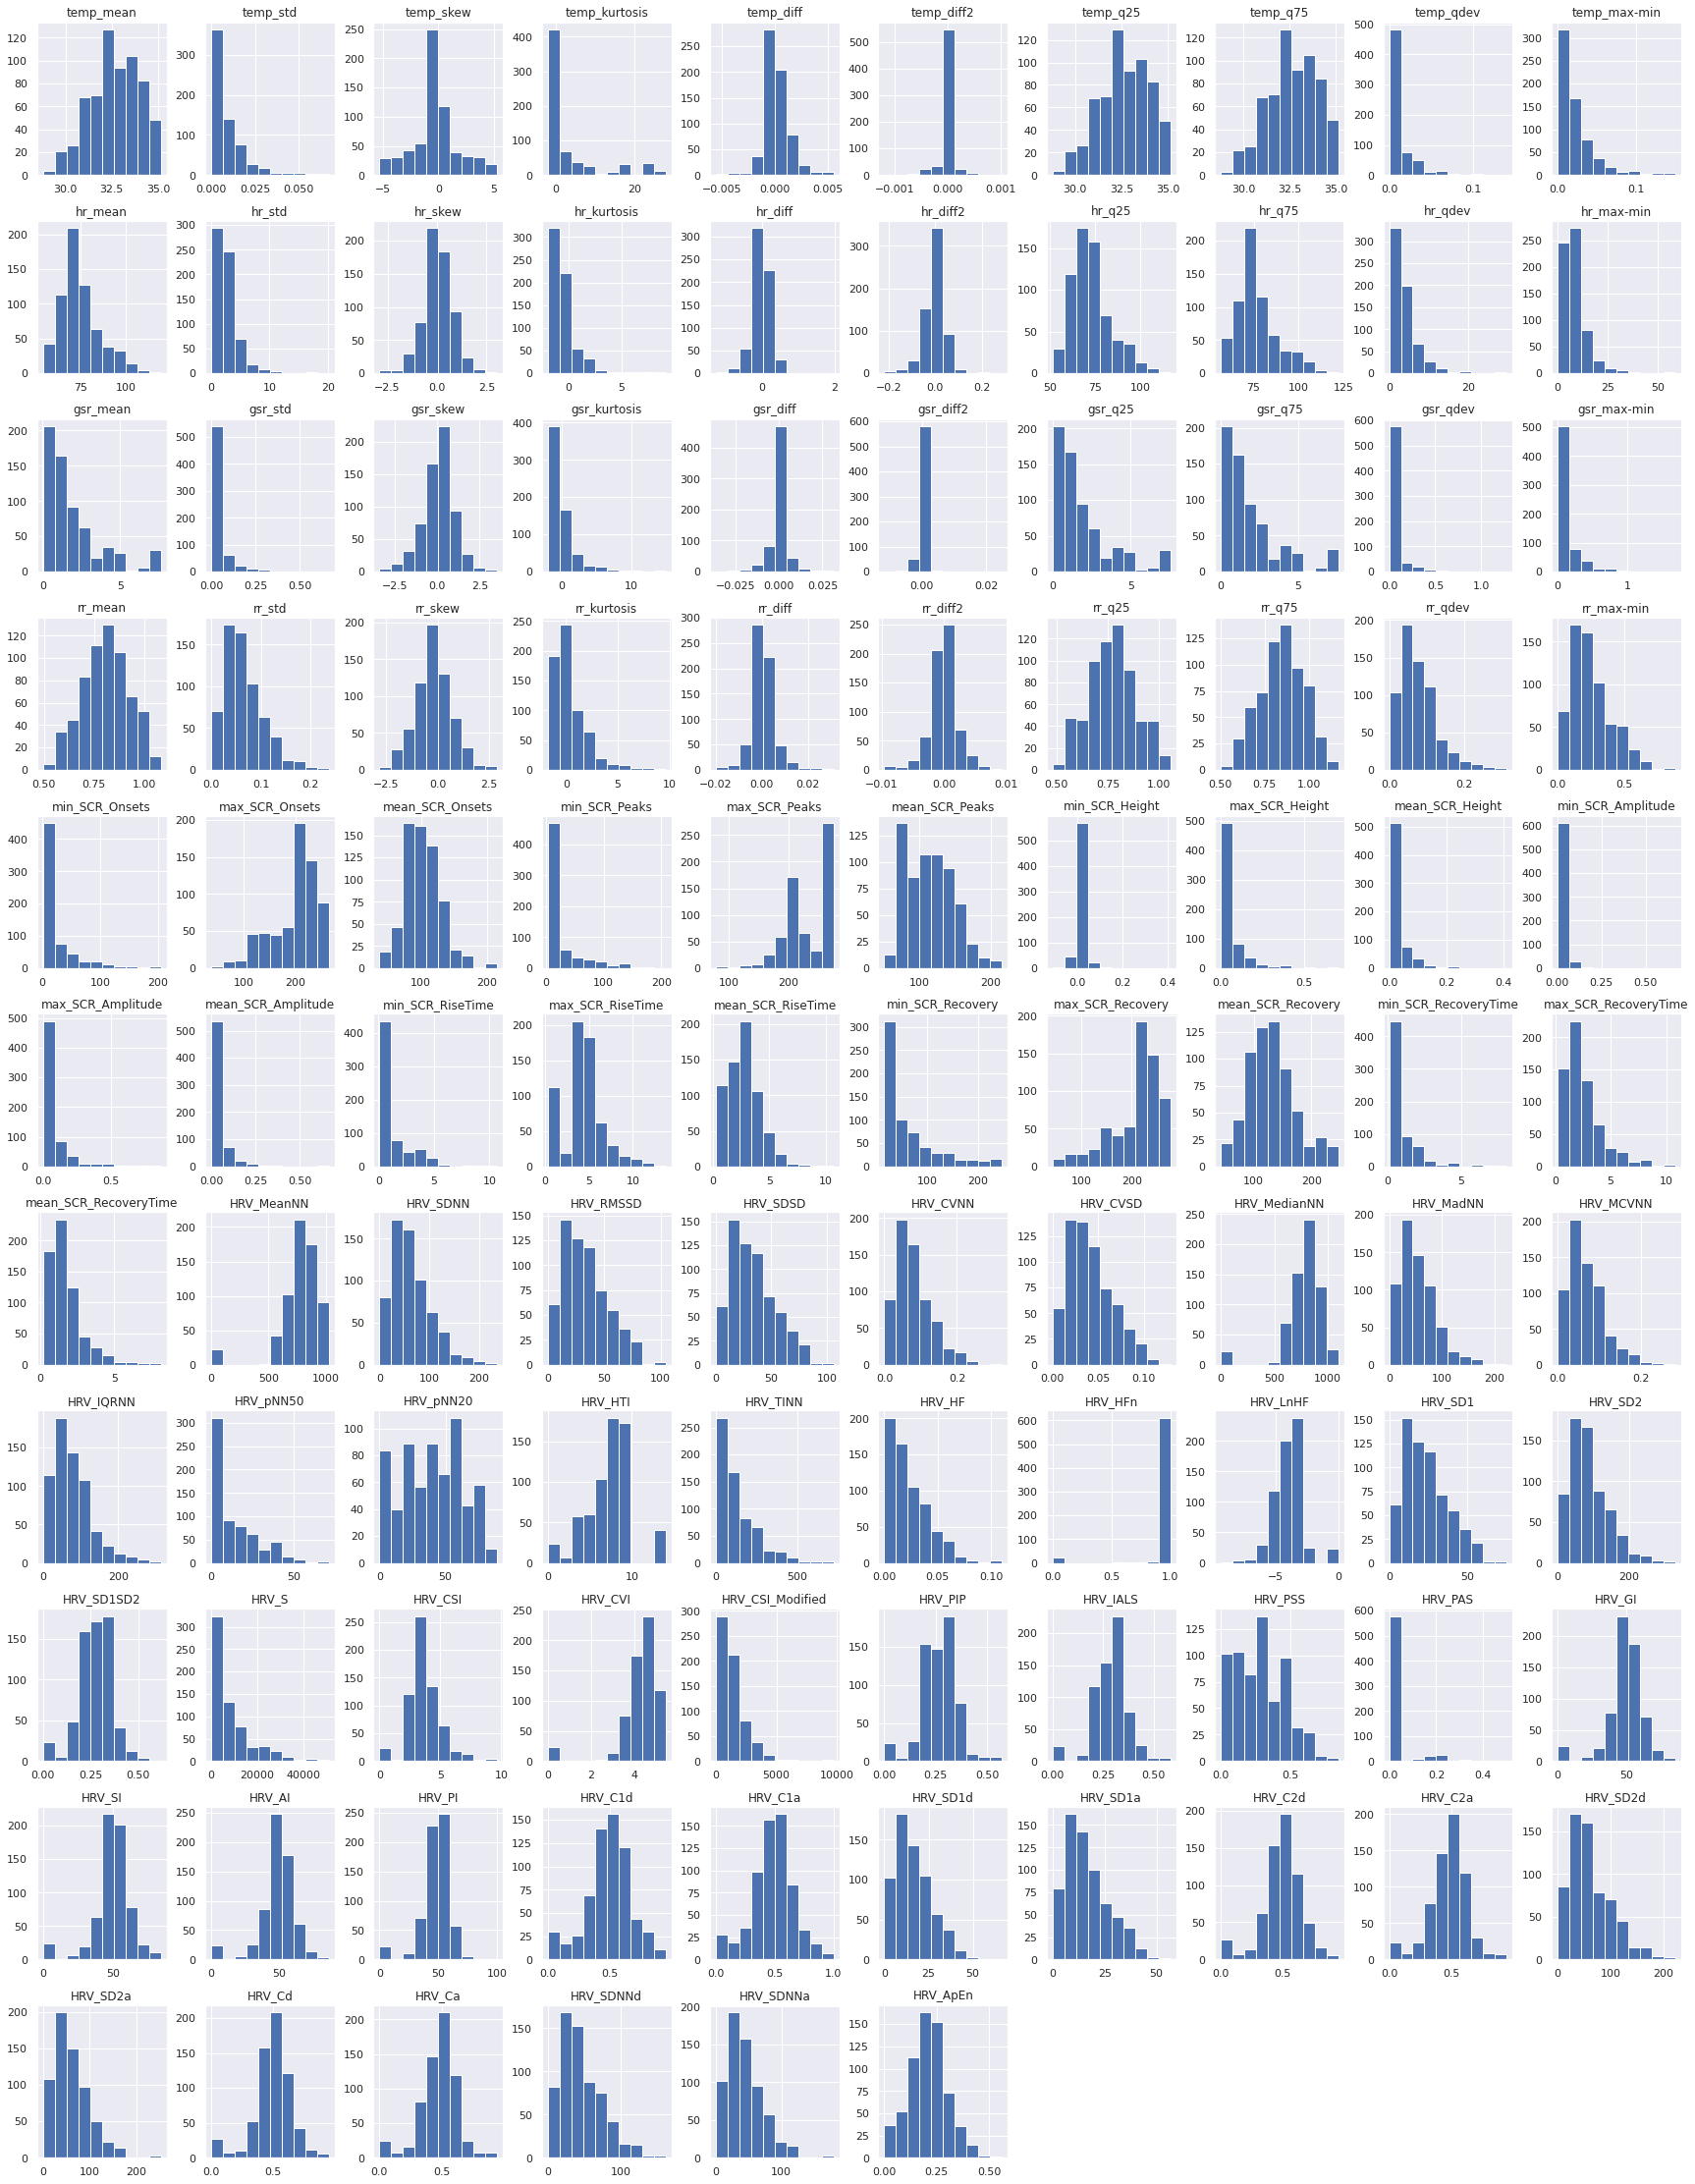

In [93]:
# plot distribution of training features
X_train.hist(figsize=(30, 40))
plt.show()

In [94]:
N_SPLITS = 5

Majority

In [95]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

print("Majority classification report:")
print(classification_report(y_test, y_pred))

Majority classification report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66        95
           1       0.00      0.00      0.00        98

    accuracy                           0.49       193
   macro avg       0.25      0.50      0.33       193
weighted avg       0.24      0.49      0.32       193



Random Forest

In [96]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

AdaBoost

In [97]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

*k*-Nearest Neighbors

In [98]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Naive Bayes

In [118]:
# https://scikit-learn.org/stable/modules/naive_bayes.html

estimator = GaussianNB()
clf = cross_validate(
    estimator=estimator,
    X=X_train,
    y=y_train,
    scoring="accuracy",
    cv=N_SPLITS,
    n_jobs=-1,
)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

print("Naive Bayes classification report")
print(classification_report(y_test, y_pred))

Naive Bayes classification report
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        95
           1       0.55      0.65      0.60        98

    accuracy                           0.55       193
   macro avg       0.56      0.55      0.55       193
weighted avg       0.56      0.55      0.55       193



In [119]:
estimator = GaussianNB()
fs_clf = RFECV(
    estimator=estimator,
    step=1,
    cv=N_SPLITS,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=-1,
)

fs_clf.fit(X_train, y_train)
y_pred = fs_clf.predict(X_test)

selected_features = X_train.columns[fs_clf.ranking_ == 1]

print("Naive Bayes classification report")
print(classification_report(y_test, y_pred))

print("Selected features:", selected_features)

ValueError: when `importance_getter=='auto'`, the underlying estimator GaussianNB should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

Decision Tree

In [100]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Decision tree classification report:")
print(classification_report(y_test, y_pred))

Decision tree classification report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        95
           1       0.62      0.54      0.58        98

    accuracy                           0.60       193
   macro avg       0.60      0.60      0.59       193
weighted avg       0.60      0.60      0.59       193



Logistic Regression

In [101]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Bagging

In [102]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

XGBoost

In [103]:
gk = GroupKFold(n_splits=5)  # TODO try 5-fold
splits = gk.get_n_splits(X_train, y_train, TRAIN_IDS)
print(type(gk))

<class 'sklearn.model_selection._split.GroupKFold'>


In [104]:
# ≈ 2 s

estimator = XGBClassifier(n_jobs=-1)
clf = cross_validate(
    estimator=estimator,
    X=X_train,
    y=y_train,
    scoring="accuracy",
    cv=N_SPLITS,
    n_jobs=-1,
)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

print("XGBoost classification report")
print(classification_report(y_test, y_pred))

XGBoost classification report
              precision    recall  f1-score   support

           0       0.63      0.54      0.58        95
           1       0.61      0.69      0.65        98

    accuracy                           0.62       193
   macro avg       0.62      0.62      0.61       193
weighted avg       0.62      0.62      0.61       193



In [105]:
# ≈ 2 min

import time

s = time.time()

estimator = XGBClassifier(n_jobs=-1)
fs_clf = RFECV(
    estimator=estimator,
    step=1,
    cv=N_SPLITS,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=-1,
)

fs_clf.fit(X_train, y_train)
y_pred = fs_clf.predict(X_test)

selected_features = X_train.columns[fs_clf.ranking_ == 1]

print("XGBoost classification report")
print(classification_report(y_test, y_pred))

print("Selected features:", selected_features)

print(time.time() - s)

XGBoost classification report
              precision    recall  f1-score   support

           0       0.62      0.58      0.60        95
           1       0.62      0.65      0.63        98

    accuracy                           0.62       193
   macro avg       0.62      0.62      0.62       193
weighted avg       0.62      0.62      0.62       193

Selected features: Index(['temp_skew', 'hr_skew', 'hr_diff2', 'hr_qdev', 'gsr_mean', 'gsr_std',
       'gsr_max-min', 'rr_skew', 'rr_q25', 'rr_qdev', 'HRV_RMSSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MCVNN', 'HRV_LnHF', 'HRV_PI', 'HRV_C1d'],
      dtype='object')
85.3044867515564


Multitask Learning

Multilayer Perceptron